In [15]:
import pandas as pd
import random

In [17]:
data_original = pd.read_csv('./original.csv')
data = data_original['Price']
for index in range(len(data)):
    data[index] += data[index]*random.randint(-20,20)/100
data_original['Price'] = data
data_original.to_csv('./train.csv',index=False)

/var/folders/vq/lr9jr0w132n5fxzlgyfxgg3h0000gn/T/ipykernel_83532/2692517942.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[index] += data[index]*random.randint(0,20)/100


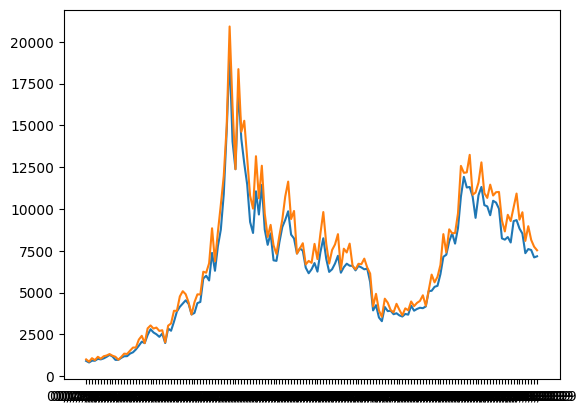

In [18]:
import matplotlib
import matplotlib.pyplot as plt


data = pd.read_csv('./original.csv')
data_new = pd.read_csv('./train.csv')
plt.plot(data['Date'],data['Price'],data_new['Date'],data_new['Price'])